In [1]:
!pip install wandb -qU
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import nltk
from collections import Counter
import re
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from collections import Counter
import torch.optim as optim
from string import punctuation
from torch.utils.data import DataLoader, TensorDataset
tqdm.pandas()

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

import wandb
wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 2.4 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [2]:
df = pd.read_csv('/content/drive/MyDrive/Language Detection/Language Detection.csv')
languages = ['English','Portugeese','French','Dutch','Spanish','Greek','Russian','Danish','Italian','Sweedish','German']
to_drop = [language for language in df.Language.unique() if language not in languages]
for language in to_drop:
  df = df.loc[df["Language"] != language]


redecoded = {}
for language in languages:
  redecoded[language] = language.lower()
redecoded['Portugeese'] = 'portuguese'
redecoded['Sweedish'] = 'swedish'

for language in df.Language.unique():
  df.loc[df.Language == language, 'Language'] = redecoded[language]
languages = df.Language.unique()
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",english
1,"""Nature"" can refer to the phenomena of the phy...",english
2,"The study of nature is a large, if not the onl...",english
3,"Although humans are part of nature, human acti...",english
4,[1] The word nature is borrowed from the Old F...,english


In [3]:
def count_mising_samples(df):
    missing_values_count = df.isna().sum()
    print(missing_values_count)

def calculate_statistics(df,languages = languages):
    statistics = {language: np.array([]) for language in languages}
    for language in languages:
      for sentences in df.Text[df['Language'] == language]:
        statistics[language] = np.append(statistics[language],len(sentences))
      statistics[language] = {'mean': statistics[language].mean(),'std':statistics[language].std()}
    x_axis = np.arange(0, 500, 0.01)
    plt.figure(figsize=(15, 6))
    for language in languages:
      plt.plot(x_axis, norm.pdf(x_axis, statistics[language]['mean'], statistics[language]['std']) ,label = language)
      plt.xticks(np.arange(0, 500, 25) )
      plt.grid()
      plt.legend()
    plt.show()
    return statistics

def number_of_samples(df,by_column):
    label_counts = df[by_column].value_counts()
    plt.figure(figsize=(10, 6))
    label_counts.plot(kind='bar')
    plt.xlabel('Labels')
    plt.ylabel('Number of Samples')
    plt.title('Histogram of Label Counts')
    plt.show()


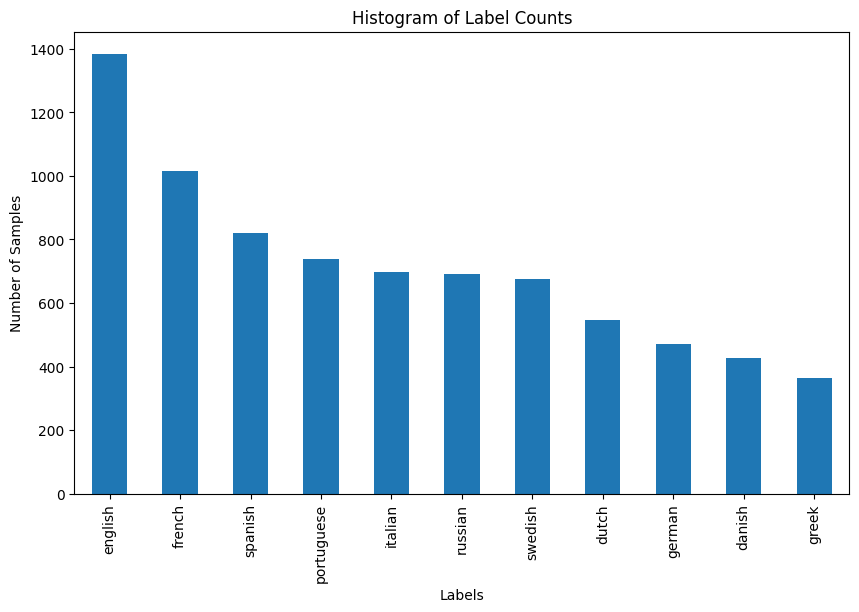

In [4]:
number_of_samples(df,'Language')

In [5]:
count_mising_samples(df)

Text        0
Language    0
dtype: int64


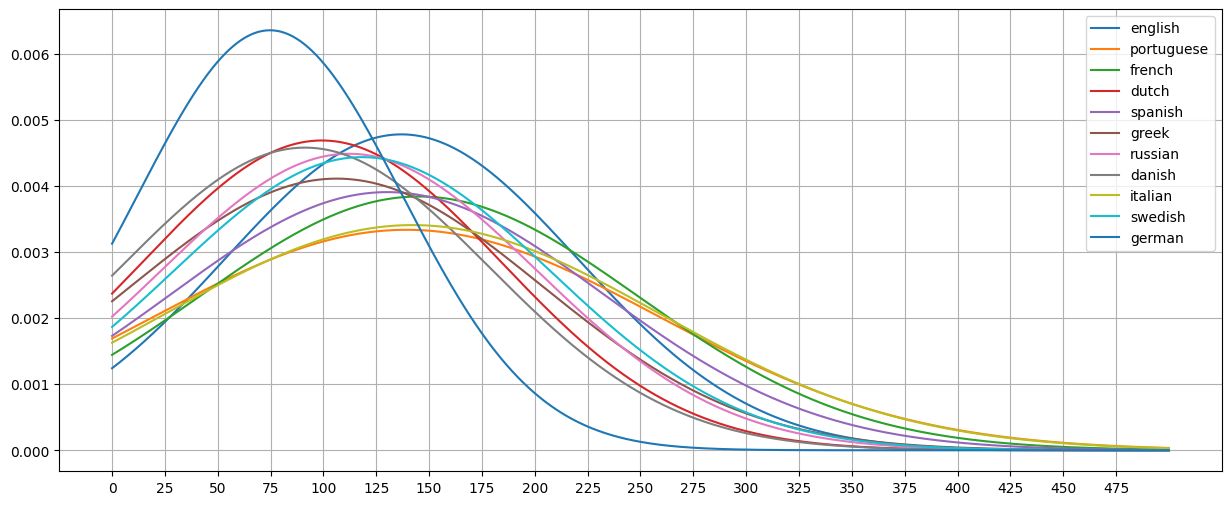

In [6]:
statistics = calculate_statistics(df)

In [7]:
# cleaning the text from no letters and numbers
# lemmatize them: blending -> blend
# and remove stop words from text
def clean_text(text, language):
    punc = set(punctuation)
    stop_words = set(nltk.corpus.stopwords.words(language))
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
    text = text.lower()  # Convert to lowercase
    for word in text:
      for ch in word:
        if ch == ' ':
          continue
        if ch.lower() == ch.upper():
          text = text.replace(ch, "")

    text = word_tokenize(text,language=language)  # Tokenize
    text = [word for word in text if word not in stop_words]
    text = [lemmatizer.lemmatize(t) for t in text]
    text = [word for word in text if word not in stop_words]
    return text


def build_vocab(min_freq = 2, df = df):
  all_tokens = [token for sublist in df['tokens'] for token in sublist]
  counter = Counter(all_tokens)
  vocabular = {word: i+2  for i, (word, feq) in enumerate(counter.most_common()) if feq > min_freq}
  vocabular['<PAD>'] = 0
  vocabular['<UNK>'] = 1
  return vocabular, counter


# Define pad features function
def pad_features(reviews, pad_id, seq_length=128):
    # features = np.zeros((len(reviews), seq_length), dtype=int)
    features = np.full((len(reviews), seq_length), pad_id, dtype=int)

    for i, row in enumerate(reviews):
        # if seq_length < len(row) then review will be trimmed
        features[i, max(0,seq_length - len(row)):] = np.array(row)[:min(seq_length, len(row))]

    return features

def get_data(batch_size = 64,seq_len = 128,data=df,languages=languages):

    pad_id = vocabular['<PAD>']
    for i,language in enumerate(languages):
      if i == 0:
        features = pad_features(df.token_ids[df['Language'] == language], pad_id, seq_len)
      else:
        features = np.concatenate((features,
                                  pad_features(df.token_ids[df['Language'] == language], pad_id, seq_len)),axis = 0)

    label_dict = {l: i for i,l in enumerate(languages)}

    labels = df['Language'].map(label_dict).values
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.3, random_state=42)

    train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
    valid_loader = DataLoader(valid_data, shuffle=True,batch_size=batch_size)

    return train_loader, valid_loader



In [8]:
df['tokens'] = None
df['token_ids'] = None

for language in languages:
  print(language)
  df.tokens[df['Language'] == language] = df.Text[df['Language'] == language].progress_apply(lambda x: clean_text(x,language))

vocabular,_ = build_vocab(df = df)

for language in languages:
  df.token_ids[df['Language'] == language] = df.tokens[df['Language'] == language].apply(lambda x: [vocabular.get(word, vocabular['<UNK>']) for word in x])

english


100%|██████████| 1385/1385 [00:01<00:00, 784.68it/s] 


portuguese


100%|██████████| 739/739 [00:00<00:00, 2347.24it/s]


french


100%|██████████| 1014/1014 [00:00<00:00, 2409.56it/s]


dutch


100%|██████████| 546/546 [00:00<00:00, 3324.52it/s]


spanish


100%|██████████| 819/819 [00:00<00:00, 2045.67it/s]


greek


100%|██████████| 365/365 [00:00<00:00, 2321.33it/s]


russian


100%|██████████| 692/692 [00:00<00:00, 1915.76it/s]


danish


100%|██████████| 428/428 [00:00<00:00, 1793.63it/s]


italian


100%|██████████| 698/698 [00:00<00:00, 1435.70it/s]


swedish


100%|██████████| 676/676 [00:00<00:00, 1633.48it/s]


german


100%|██████████| 470/470 [00:00<00:00, 1685.65it/s]


In [9]:
df

,Text,Language,tokens,token_ids
0,"Nature, in the broadest sense, is the natural...",english,"[nature, broadest, sense, natural, physical, m...","[4, 1, 3666, 230, 1400, 344, 345, 1401]"
1,"""Nature"" can refer to the phenomena of the phy...",english,"[nature, refer, phenomenon, physical, world, a...","[4, 4989, 4990, 1400, 345, 40, 59, 213]"
2,"The study of nature is a large, if not the onl...",english,"[study, nature, large, part, science]","[214, 4, 530, 91, 89]"
3,"Although humans are part of nature, human acti...",english,"[although, human, part, nature, human, activit...","[531, 115, 91, 4, 115, 1638, 231, 2911, 1402, ..."
4,[1] The word nature is borrowed from the Old F...,english,"[word, nature, borrowed, old, french, nature, ...","[43, 4, 1, 4991, 3667, 4, 1, 1920, 43, 1240, 4..."
...,...,...,...,...
9963,narcisa änderte ihre art und weise sie kämpfte...,german,"[narcisa, änderte, art, weise, kämpfte, zuerst...","[11, 1, 454, 1, 1, 1, 4963, 1, 3647, 1, 1, 153..."
9964,Wie' s Narzissmus jetzt erzählt Marian beiden ...,german,"[s, narzissmus, erzählt, marian, beiden, passi...","[433, 1, 1, 176, 1, 7090, 7158, 1816, 1]"
9965,"Hat sie, ich denke, sie würde jetzt kein Goldb...",german,"[denke, goldbrot, mehr]","[4987, 1, 2898]"
9966,"Terry, du siehst tatsächlich ein bisschen wie ...",german,"[terry, siehst, tatsächlich, bisschen, engel, ...","[60, 1, 7148, 7109, 2165, 1, 7153]"


In [10]:
all_tokens = {}
counter = {}
for language in languages:
  all_tokens[language] = [token for sublist in df.tokens[df['Language'] == language] for token in sublist]
  counter[language] = Counter(all_tokens[language])
  print(f"{language}:{counter[language].most_common()[:5]}")

english:[('wikipedia', 321), ('learning', 172), ('article', 147), ('machine', 99), ('data', 91)]
portuguese:[('wikipédia', 238), ('pode', 80), ('artigos', 77), ('sobre', 59), ('dizer', 44)]
french:[('wikipédia', 191), ('a', 149), ('nature', 129), ('plus', 117), ('comme', 103)]
dutch:[('wikipedia', 71), ('kunt', 49), ('zeggen', 45), ('woord', 35), ('goed', 34)]
spanish:[('wikipedia', 184), ('artículos', 80), ('si', 78), ('puedes', 52), ('persona', 42)]
greek:[('είναι', 125), ('ότι', 92), ('σας', 78), ('από', 76), ('μια', 73)]
russian:[('это', 131), ('википедии', 100), ('года', 66), ('википедия', 56), ('можете', 48)]
danish:[('kan', 106), ('så', 76), ('sige', 43), ('ord', 38), ('nogen', 37)]
italian:[('wikipedia', 144), ('puoi', 66), ('voci', 62), ('essere', 58), ('automatico', 43)]
swedish:[('wikipedia', 131), ('säga', 46), ('artiklar', 44), ('ord', 40), ('andra', 39)]
german:[('sagen', 53), ('bedeutet', 25), ('wort', 25), ('gut', 25), ('kannst', 22)]


In [11]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx,dropout=None, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True,bidirectional=bidirectional)
        if self.bidirectional == False:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = dropout
        if dropout is not None:
            self.drop = nn.Dropout(dropout)

    def forward(self, text):
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, len(text), self.hidden_dim,device=device)
        else:
            h0 = torch.zeros(self.num_layers, len(text), self.hidden_dim,device=device)
        embedded = self.embedding(text)
        embedded = embedded.to(torch.float32)
        Y, _ = self.rnn(embedded,h0)
        output = self.fc(Y)
        if self.dropout is not None:
            output = self.drop(output)
        return output[:,-1,:]


In [12]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx,dropout=None, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True,bidirectional=bidirectional)
        if self.bidirectional == False:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = dropout
        if dropout is not None:
            self.drop = nn.Dropout(dropout)

    def forward(self,text):
        if self.bidirectional:
            c0 = torch.zeros(self.num_layers*2, len(text), self.hidden_dim,device=device)
            h0 = torch.zeros(self.num_layers*2, len(text), self.hidden_dim,device=device)
        else:
            c0 = torch.zeros(self.num_layers, len(text), self.hidden_dim,device=device)
            h0 = torch.zeros(self.num_layers, len(text), self.hidden_dim,device=device)
        embedded = self.embedding(text)
        embedded = embedded.to(torch.float32)
        Y, _ = self.rnn(embedded,(h0,c0))
        output = self.fc(Y)
        if self.dropout is not None:
            output = self.drop(output)
        return output[:,-1,:]


In [13]:
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, pad_idx,dropout=None, bidirectional=False):
        super().__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True,bidirectional=bidirectional)
        if self.bidirectional == False:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc = nn.Linear(hidden_dim*2, output_dim)
        self.dropout = dropout
        if dropout is not None:
            self.drop = nn.Dropout(dropout)

    def forward(self, text):
        if self.bidirectional:
            h0 = torch.zeros(self.num_layers*2, len(text), self.hidden_dim,device=device)
        else:
            h0 = torch.zeros(self.num_layers, len(text), self.hidden_dim,device=device)
        embedded = self.embedding(text)
        embedded = embedded.to(torch.float32)
        Y, _ = self.rnn(embedded,h0)
        output = self.fc(Y)
        if self.dropout is not None:
            output = self.drop(output)
        return output[:,-1,:]


In [22]:
sweep_config = {
    'method': 'random'
    }

metric = {
    'name': 'valid accuracy',
    'goal': 'maximize',
    'target': 1.0
    }
sweep_config['metric'] = metric
sweep_config['name'] = 'LSTM tuning language detection dataset'
parameters_dict = {
    'num_hidden': {
        'values': [1, 32, 64]
        },
    'embedded_size': {
        'values': [128, 256, 512]
        },
    'num_layers': {
        'values': [1, 2, 4,8]
        },
    'bidirectional': {
        'values': [False,True]
        },
    'dropout': {
          'values': [0, 0.3, 0.4, 0.5]
        },
    'learning_rate':{
        'values':[0.001, 0.005, 0.01]
    },
    'batch_size':{
        'values':[32,64,128]
    },
    'seq_len':{
        'values':[32,64,128]
    }
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 100}
    })



In [29]:
sweep_id = wandb.sweep(sweep_config, project="Language Recognition")

Create sweep with ID: xltsui5s
Sweep URL: https://wandb.ai/mlteamaau/Language%20Recognition/sweeps/xltsui5s


In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def init_model(embedded_size,num_hidden,num_layers,dropout,bidirectional):
    return GRU(len(vocabular),embedded_size, num_hidden, len(languages), num_layers, vocabular['<PAD>'],dropout,bidirectional)

def init_optimizer(model,lr):
    return optim.Adam(model.parameters(),lr=lr)

def log(metrics):
    wandb.log(metrics)

def evaluate(model,iterator,criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    n = 0

    model.eval()

    with torch.no_grad():
        for texts, labels in iterator:
            texts, labels = texts.to(device), labels.to(device)
            predictions = model(texts)
            loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
            THP = torch.argmax(predictions, dim = 1)
            epoch_accuracy += (THP == labels).float().mean().item()
            n += 1
            epoch_loss += loss.item()

    return epoch_loss / len(iterator), epoch_accuracy/n

def train(model,iterator,optimizer,criterion):
    epoch_loss = 0
    epoch_accuracy = 0
    n = 0

    model.train()

    for texts, labels in iterator:
        texts, labels = texts.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(texts)
        loss = criterion(predictions, labels.type(torch.LongTensor).to(device))
        loss.backward()
        optimizer.step()
        THP = torch.argmax(predictions, dim = 1)
        epoch_accuracy += (THP == labels).float().mean().item()
        n += 1
        epoch_loss += loss.item()

    return epoch_loss / len(iterator), epoch_accuracy/n

def fit(config=None):
    with wandb.init(config=config,name='GRU'):
        config = wandb.config


        train_loader, valid_loader = get_data(config.batch_size,config.seq_len)
        model = init_model(config.embedded_size,config.num_hidden,config.num_layers,config.dropout,config.bidirectional).to(device)
        optimizer = init_optimizer(model,config.learning_rate)
        criterion = nn.CrossEntropyLoss().to(device)
        scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=100)
        for epoch in tqdm(range(config.epochs)):

            train_loss,train_accuracy = train(model, train_loader, optimizer, criterion)
            valid_loss,valid_accuracy = evaluate(model, valid_loader, criterion)
            wandb.log({
                'training loss':train_loss,
                'training accuracy': train_accuracy,
                'valid loss':valid_loss,
                'valid accuracy': valid_accuracy,
            })

            scheduler.step()

In [31]:
wandb.agent(sweep_id, fit)

wandb: Agent Starting Run: 3nvcf5t7 with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	num_hidden: 32
wandb: 	num_layers: 2
wandb: 	seq_len: 32


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


training accuracy,▁███████████████████████████████████████
training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▇█▇█▇▇███████▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
valid loss,█▁▁▂▁▁▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
training accuracy,0.96104
training loss,0.10368
valid accuracy,0.87066
valid loss,0.52357


wandb: Agent Starting Run: kucy2pp1 with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	embedded_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 64
wandb: 	num_layers: 8
wandb: 	seq_len: 32


100%|██████████| 100/100 [01:56<00:00,  1.16s/it]


training accuracy,▁▅▇█████████████████████████████████████
training loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▅▇▇▇▇▇▇████████████████████████████████
valid loss,█▃▂▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▄▄
training accuracy,0.7899
training loss,0.46946
valid accuracy,0.81521
valid loss,1.29131


wandb: Agent Starting Run: n8gu64nb with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	dropout: 0.5
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	num_hidden: 1
wandb: 	num_layers: 1
wandb: 	seq_len: 32


100%|██████████| 100/100 [01:06<00:00,  1.51it/s]


training accuracy,▁▄▆▆▆▇▆▆▇▇▇▆▇▆▇▇▇█▇▇▇▇█▇▇█▇▇▇▇█▇▇██▇▇███
training loss,█▅▄▃▃▂▂▂▂▂▂▂▁▂▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
valid accuracy,▄▅▇▆▇▁▇▇▂█▇▆▆▆▆▆▆▆▆▆▆▆▆▇▇▃▆▇▇▇██████████
valid loss,█▆▅▅▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁
training accuracy,0.20211
training loss,2.23287
valid accuracy,0.21109
valid loss,2.26743


wandb: Agent Starting Run: qygxf92v with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	dropout: 0.3
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 32
wandb: 	num_layers: 8
wandb: 	seq_len: 128


100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


training accuracy,▁▃▆▆▇███████████████████████████████████
training loss,█▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▄▅▆▇▇▇▇▇▇▇█████████████████████████████
valid loss,█▄▂▁▁▁▁▁▁▂▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
training accuracy,0.78719
training loss,0.4927
valid accuracy,0.77976
valid loss,1.13167


wandb: Agent Starting Run: bq8xly9i with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	dropout: 0.4
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 64
wandb: 	num_layers: 2
wandb: 	seq_len: 32


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]


training accuracy,▁▅▇▇████████████████████████████████████
training loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▆██████████████████████████████████████
valid loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▂▁▁▂▁▂▂
training accuracy,0.70799
training loss,0.70736
valid accuracy,0.83368
valid loss,0.72088


wandb: Agent Starting Run: 93u5socm with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	dropout: 0.4
wandb: 	embedded_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 32
wandb: 	num_layers: 4
wandb: 	seq_len: 64


100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


training accuracy,▁▃▅▆▇▇██████████████████████████████████
training loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▃▆▇▇███████████████████████████████████
valid loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
training accuracy,0.7037
training loss,0.71057
valid accuracy,0.7699
valid loss,0.99181


wandb: Agent Starting Run: h5jfs4nl with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	dropout: 0
wandb: 	embedded_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	num_hidden: 64
wandb: 	num_layers: 4
wandb: 	seq_len: 128


100%|██████████| 100/100 [02:13<00:00,  1.33s/it]


training accuracy,▁▇██████████████████████████████████████
training loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▆▇▇▆▇█▇███▆█▇███████▇██████████████████
valid loss,▇▁▂▃▄▃▄▅▅▆▆▇▃▄▄▅▅▅▅▅▅▇▅▆▆▆▆▆▇▇▇▇▇█▇▇████
training accuracy,0.96185
training loss,0.10261
valid accuracy,0.84827
valid loss,0.98725


wandb: Agent Starting Run: iq563mmm with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: False
wandb: 	dropout: 0.5
wandb: 	embedded_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 64
wandb: 	num_layers: 4
wandb: 	seq_len: 64


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]


training accuracy,▁▆▇█████████████████████████████████████
training loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▆██████████████████████████████████████
valid loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.60805
training loss,0.95435
valid accuracy,0.83947
valid loss,0.60237


wandb: Agent Starting Run: 9wgrv0gm with config:
wandb: 	batch_size: 128
wandb: 	bidirectional: False
wandb: 	dropout: 0.4
wandb: 	embedded_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 32
wandb: 	num_layers: 4
wandb: 	seq_len: 64


100%|██████████| 100/100 [00:30<00:00,  3.26it/s]


training accuracy,▁▄▇▇████████████████████████████████████
training loss,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▅▇▇████████████████████████████████████
valid loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.69955
training loss,0.72219
valid accuracy,0.80353
valid loss,0.77827


wandb: Agent Starting Run: ksozmig9 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.5
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 64
wandb: 	num_layers: 8
wandb: 	seq_len: 64


100%|██████████| 100/100 [01:50<00:00,  1.11s/it]


training accuracy,▁▆▇█████████████████████████████████████
training loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▆▇▇█▇██████████████████████████████████
valid loss,█▃▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃▃▃▃▃▃▃
training accuracy,0.61894
training loss,0.94379
valid accuracy,0.80932
valid loss,0.97006


wandb: Agent Starting Run: gen5pimw with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: True
wandb: 	dropout: 0.4
wandb: 	embedded_size: 512
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	num_hidden: 1
wandb: 	num_layers: 1
wandb: 	seq_len: 128


100%|██████████| 100/100 [01:23<00:00,  1.20it/s]


training accuracy,▁▅▅▅▆▇▇▇▇▇▇▆▇▇▇██▇▇▇▇▇▇▇▇▇▇███▇█▇▇▇▇▇▇▇▇
training loss,█▄▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▄▅▆▆▅▆▇▇▇▆▇▇▇▇▇▆▆▇▆▆▇▆▇▇▇▇▇████████████
valid loss,█▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.26479
training loss,2.06178
valid accuracy,0.25712
valid loss,2.1428


wandb: Agent Starting Run: t8rlojzf with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.5
wandb: 	embedded_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	num_hidden: 1
wandb: 	num_layers: 2
wandb: 	seq_len: 32


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


training accuracy,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇▇█▇██████
training loss,█▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁
valid accuracy,▁▂▂▄▄▄▅▅▆▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████
valid loss,█▆▅▅▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.37651
training loss,1.81035
valid accuracy,0.35559
valid loss,1.77169


wandb: Agent Starting Run: 4zueexd1 with config:
wandb: 	batch_size: 64
wandb: 	bidirectional: True
wandb: 	dropout: 0.3
wandb: 	embedded_size: 256
wandb: 	epochs: 100
wandb: 	learning_rate: 0.01
wandb: 	num_hidden: 64
wandb: 	num_layers: 8
wandb: 	seq_len: 32


100%|██████████| 100/100 [01:16<00:00,  1.31it/s]


training accuracy,▁▂▃▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇████████████
training loss,█▇▆▆▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▂▄▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
valid loss,█▇▅▄▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄
training accuracy,0.76858
training loss,0.53905
valid accuracy,0.65596
valid loss,1.72506


wandb: Agent Starting Run: 8g6hp4st with config:
wandb: 	batch_size: 32
wandb: 	bidirectional: False
wandb: 	dropout: 0.5
wandb: 	embedded_size: 128
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	num_hidden: 32
wandb: 	num_layers: 4
wandb: 	seq_len: 64


100%|██████████| 100/100 [01:07<00:00,  1.47it/s]


training accuracy,▁▆▇▇█████▇██████████████████████████████
training loss,█▄▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▆▇█████▇███████████████████████████████
valid loss,█▃▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.60977
training loss,0.95432
valid accuracy,0.85678
valid loss,0.60043


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [21]:
config = {
    'num_hidden':65,
    'embedded_size':512,
    'num_layers':1,
    'bidirectional':True,
    'dropout':0.0,
    'learning_rate':0.001,
    'batch_size': 64,
    'seq_len':256,
    'epochs':100

}
fit(config)

100%|██████████| 100/100 [01:28<00:00,  1.12it/s]


training accuracy,▁▂▂▃▃▄▅▅▆▆▇▇▇▇▇█████████████████████████
training loss,███▇▇▇▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid accuracy,▁▁▂▂▃▃▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████████
valid loss,███▇▇▇▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training accuracy,0.95057
training loss,0.34193
valid accuracy,0.76491
valid loss,0.89071
